In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor
%matplotlib inline

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

Our target variable is SalePrice so lets check correlation between predictor variables and our target

In [4]:
corr = df_train.corr()
corr['SalePrice']

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

None of the negative correlations are significant so I'm going to ignore those

In [5]:
corr['SalePrice'][corr['SalePrice'] >= 0.6]

OverallQual    0.790982
TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
SalePrice      1.000000
Name: SalePrice, dtype: float64

These are our most important features at the moment, but some of them seem to represent the same information for each of our records. For example, GarageArea and GarageCars seem very correlated. Let's check out the correlation heatmap to see if it's true.

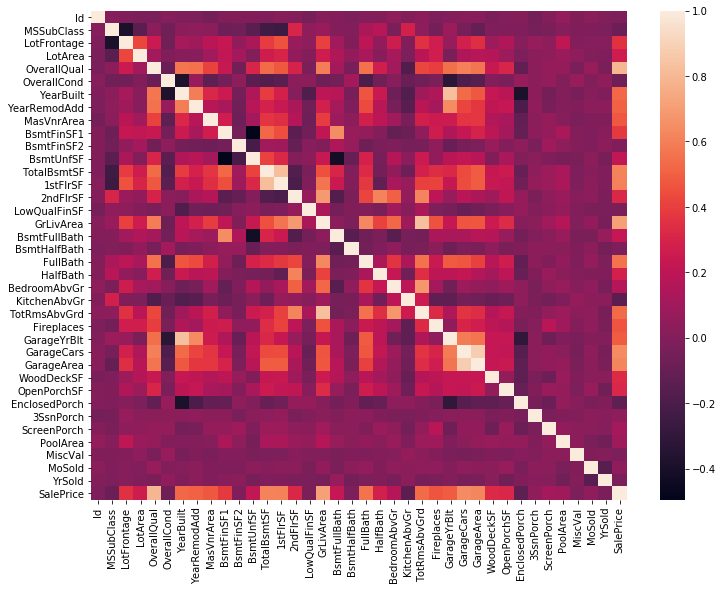

In [6]:
plt.subplots(figsize=(12, 9))

sns.heatmap(corr)

Taking a quick look we see some strange light colored squares grouped together. This confirms a high correlation between 1stFlrSF vs TotalBsmtSF and GarageArea vs GarageCars.

Since we've confirmed that these features are correlated and convey the same information, we'll pick GarageCars and TotalBsmtSF. GarageCars was picked because it's a consequence of the area of the garage and TotalBsmtSF as well since it has a higher correlation with SalesPrice.

There are other important features that we could use such as YearBuilt and some feature engineering, but for now lets just see how accurate our model is with only these.

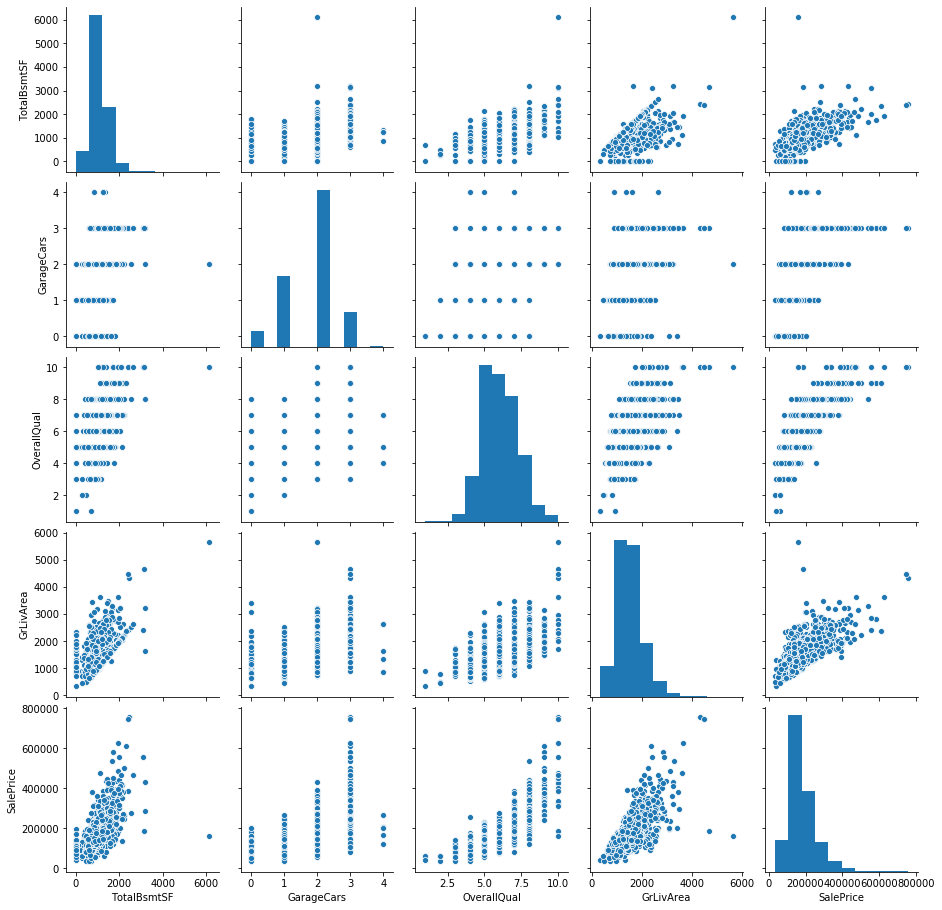

In [7]:
# Columns we decide to keep
cols = ['TotalBsmtSF', 'GarageCars', 'OverallQual', 'GrLivArea', 'SalePrice']

sns.pairplot(df_train[cols])

We can clearly see now the linear relationship between our features considered important and SalePrice. GarageCars is discrete, but we can treat is as continuous since a linear regression seems promissing.

Now that we've chosen our features to include in our model and verified that they do have a relationship with our response variable lets check for outliers + missing data so our model can perform well in production.

In [8]:
# df_train with only important columns
df_train_imp = df_train[cols]

In [9]:
df_train_imp.isnull().sum()

TotalBsmtSF    0
GarageCars     0
OverallQual    0
GrLivArea      0
SalePrice      0
dtype: int64

No missing data in our selected columns so we're good to go and no imputing to do. Lets check for outliers. For a simple analysis I like to use box plots.

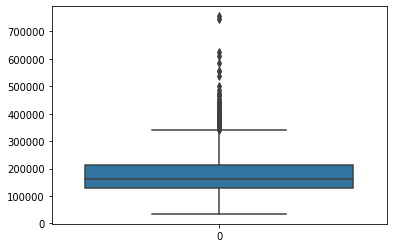

In [10]:
sns.boxplot(data=df_train_imp['SalePrice'])

Nothing strange so far, but it seems we have 2 values that are really high. I'm not sure if they're outliers or not because they could just be some really expensive houses.

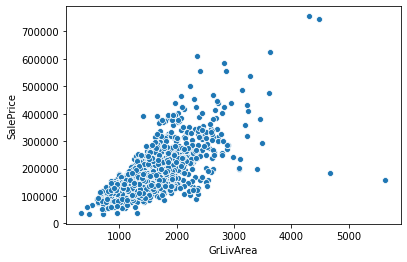

In [11]:
sns.scatterplot(x=df_train_imp['GrLivArea'], y=df_train_imp['SalePrice'])

Those 2 dots in the upper right area are the two "outliers" that we saw in the boxplot. They're not really a problem in this case since they seem to be following the pattern. We can delete the ones with really big living area, but low sale price. Maybe the house was very run down or in a rural area.

In [12]:
df_train_imp.sort_values(by = 'GrLivArea', ascending = False)

,TotalBsmtSF,GarageCars,OverallQual,GrLivArea,SalePrice
1298,6110,2,10,5642,160000
523,3138,3,10,4676,184750
1182,2396,3,10,4476,745000
691,2444,3,10,4316,755000
1169,1930,3,10,3627,625000
...,...,...,...,...,...
528,528,0,4,605,86000
29,520,1,4,520,68500
916,480,1,2,480,35311
1100,290,1,2,438,60000


The potential outliers are in good condition so it's probably a rural or distant area and doesn't seem to be similar to our other observations. Let's remove them.

In [13]:
rows_to_remove = df_train_imp.sort_values(by = 'GrLivArea', ascending = False)[:2].index

In [14]:
df_train_imp = df_train_imp.drop(rows_to_remove)

Lets do this same process with our other features. There seems to be some houses with really big basements.

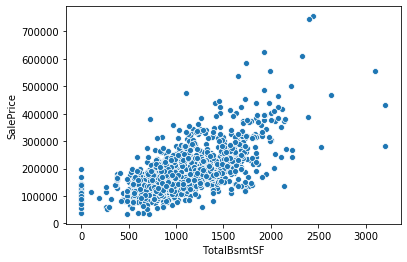

In [15]:
sns.scatterplot(x=df_train_imp['TotalBsmtSF'], y=df_train_imp['SalePrice'])

Log transform SalePrice so we can see the relationship clearer.

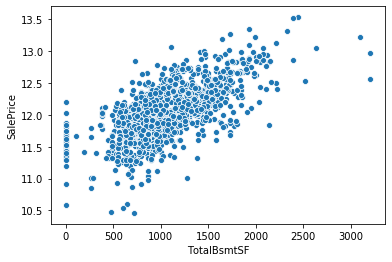

In [16]:
sns.scatterplot(x=df_train_imp['TotalBsmtSF'], y=np.log(df_train_imp['SalePrice']))

There are some houses with giant basements bigger than 3000 sqft and it's not normal for a house to have that big of a basement. Are they trying to build a bunker?? They don't seem normal and aren't following the trend, so lets remove them.

In [17]:
rows_to_remove = df_train_imp.sort_values(by = 'TotalBsmtSF', ascending = False)[:3].index

df_train_imp = df_train_imp.drop(rows_to_remove)

Looks good now :)

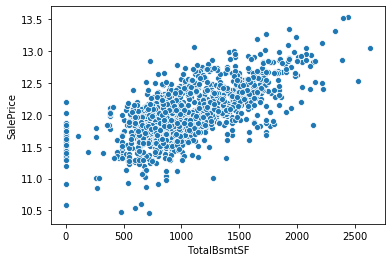

In [18]:
sns.scatterplot(x=df_train_imp['TotalBsmtSF'], y=np.log1p(df_train_imp['SalePrice']))

In [19]:
df_train['SalePrice'].std()

79442.50288288663

Our relationships look very linear so lets start off with a linear regression. One of the assumptions for linear regression is homoscedasticity. The mean SalePrice of our data set is ~180,000 USD and has a standard deviation of ~80,000 USD. If we predict a house is worth 250k, it can easily actually be worth between 170-330k. 

Imagine if we predict a house is worth 100k, the same standard deviation of 80k is very unlikely to be true for that person. 

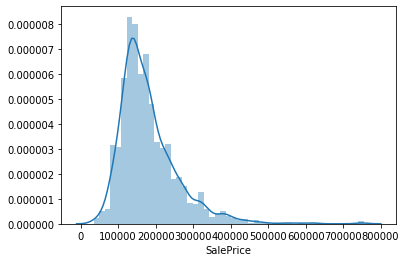

In [20]:
sns.distplot(df_train_imp['SalePrice'])

We can clearly see above that SalePrice is positively skewed and not normal, but we can make it log-normal which is fine for linear regression. Im using log(x + 1) instead of log(x) since I know BsmtSF can be 0. 

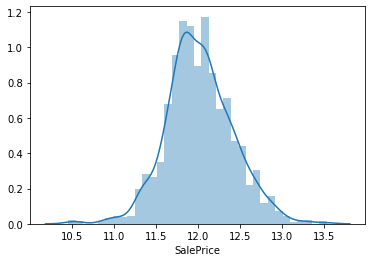

In [21]:
sns.distplot(np.log1p(df_train_imp['SalePrice']))

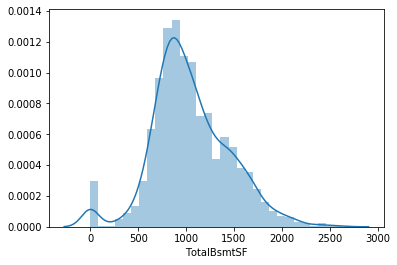

In [22]:
sns.distplot(df_train_imp['TotalBsmtSF'])

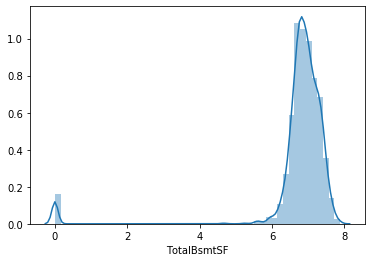

In [23]:
sns.distplot(np.log1p(df_train_imp['TotalBsmtSF']))

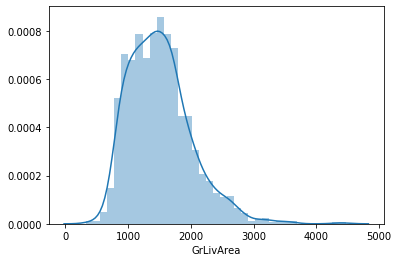

In [24]:
sns.distplot(df_train_imp['GrLivArea'])

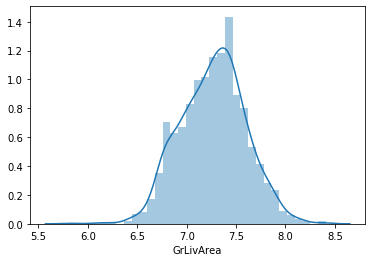

In [25]:
sns.distplot(np.log1p(df_train_imp['GrLivArea']))

In [26]:
skewed_cols = ['SalePrice', 'GrLivArea', 'TotalBsmtSF']

df_train_imp['HasBsmt'] = 

df_train_imp[skewed_cols] = np.log1p(df_train_imp[skewed_cols])
df_test[['GrLivArea', 'TotalBsmtSF']] = np.log1p(df_test[['GrLivArea', 'TotalBsmtSF']])

SyntaxError: invalid syntax (<ipython-input-26-b1c3a9b4e71b>, line 3)

Now for the fun part, lets build our model! I'm going to be using LGBMRegressor because LGBM implements gradient boost, is fast, and is usually a good starting point.

In [ ]:
lgb_regressor = LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(df_train_imp.drop('SalePrice', axis=1), df_train_imp['SalePrice'])

test_df_final = df_test[['TotalBsmtSF', 'GarageCars', 'OverallQual', 'GrLivArea']]

results = np.expm1(lgb_regressor.predict(test_df_final))

In [ ]:
df_test['SalePrice'] = results

In [ ]:
df_test[['Id', 'SalePrice']].to_csv('submission1.csv', index=False)